# P4 Computational Vision

**Important:** Read the file `README.md` before start coding.

<div class = "alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">

**Delivery**
<ol>

Requirements to fulfill:
<ul>
    <li>  Answer the questions introduced in the exercises.   
    <li>  The implemented code should be,<br>
        - optimized ( e.g. do not use 'for' instruction when indexing numpy arrays)<br>
        - readable  ( e.g. avoiding the implementation of more than 2 loops within a line)<br>
        - commented and with descriptions        
    <li> Add title to the figures to explain what is displayed.
    <li> The deliverable must be a file named **P4_Student1_Student2.zip** that includes:
    <ul>
        <li> The notebook P4_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    </ul>

</ul>

 **Deadline (Campus Virtual): October 28th, 23:00 h** 


</ol>
</div>


## Practicum 4: Descriptors extraction for object detection based on ORB


In this laboratory we will treat the following topic: Image matching (recognition by correspondance) based on feature extraction (ORB). Application to object (logo) detection.

It is highly recommendable to structure the code in functions in order to reuse code for different tests and images and make it shorter and more readable. Specially the visualization commands should be encapsulated in separate functions.

In [40]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

from skimage.feature import corner_fast, corner_peaks, ORB, match_descriptors, plot_matches
from skimage.color import rgb2gray

# ORB feature detection and description

Let us consider the problem of feature extraction that contains two subproblems: 
- feature location, 
- image feature description.

Let us focus on ORB, an approximation of SIFT method, and analyse if ORB is  scale and rotation invariant, a property that is very important for real-time applications.

**Hint:** `ORB` is a function within the module `skimage.feature`
                             
**Help**: We suggest to have a look at the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html) how to compute the ORB descriptors and find the descriptors match. You can use the function match_descriptors from `skimage.feature` module in order to compute and show the similar detected descriptors of the given images. 

**Exercise 1.** 

(a) Detect the corners in the image `starbucks4.jpg`. 
Use `corner_fast` to extract FAST corners for the given image and `corner_peaks` to find corners in the corner measure response image.

Follow this example for visualization:

    fast= corner_fast(img)
    corner_points = corner_peaks(fast)
    plt.imshow(img, cmap=plt.cm.gray)
    plt.scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')

Comment your code in detail.

(b) Analyze and discuss the effect of different values of the parameter `threshold` in the corner_fast function.



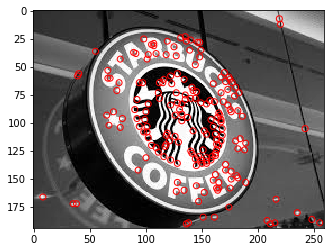

In [18]:
img = io.imread('images/starbucks4.jpg')
gs_img = rgb2gray(img)

fast = corner_fast(gs_img)
corner_points = corner_peaks(fast, threshold_rel=0.3)

plt.imshow(gs_img, cmap='gray')
plt.scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')
plt.show()

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

</div>

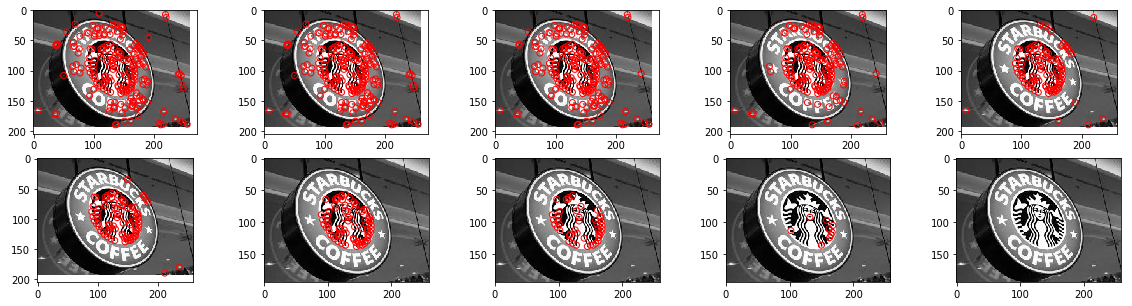

In [37]:
f, ax = plt.subplots(2, 5, figsize=(20, 5))

for idx, thresh in enumerate(np.arange(0.1, 1.1, 0.1)):
    corner_points = corner_peaks(fast, threshold_rel=thresh)

    ax[idx // 5][idx % 5].imshow(gs_img, cmap='gray')
    ax[idx // 5][idx % 5].scatter(corner_points[:, 1], corner_points[:, 0], facecolors='none', edgecolors='r')

plt.show()

**Exercise 2.** 

(a) Detect the correspondences between the model image `starbucks.jpg` with the scene image `starbucks4.jpg`. You can adapt the code from the [ORB example](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_orb.html). Define the algorithm in terms of functions in order to be able to apply it on different images. Comment the code in detail.

(b) Analyze and discuss the effect of different values of the parameter `max_ratio` in the match_descriptors function.

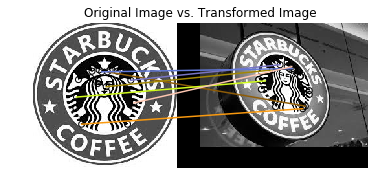

In [57]:
def display_correspondences(img1, img2, ax=plt.axes(), max_ratio=1.0):
    descriptor_extractor = ORB(n_keypoints=20)
    
    descriptor_extractor.detect_and_extract(img1)
    keypoints1 = descriptor_extractor.keypoints
    descriptors1 = descriptor_extractor.descriptors

    descriptor_extractor.detect_and_extract(img2)
    keypoints2 = descriptor_extractor.keypoints
    descriptors2 = descriptor_extractor.descriptors

    matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True, max_ratio=max_ratio)
    
    plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
    ax.axis('off')
    ax.set_title('Original Image vs. Transformed Image')

img_model = io.imread('images/starbucks.jpg')
display_correspondences(rgb2gray(img_model), gs_img)

**Exercise 3.** Repeate the experiment comparing the "starbucks.jpg" image as a model, and showing its matches to all Starbucks images. Add a title in each figure indicating the number of the matches for the pair. Comment when does the algorithm work better. 

In [40]:
# Your solution here

<div class = "alert alert-info" style = "background-color:Wheat;border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

</div>

**Exercise 4.** Repeate the experiment in exercise 3., changing the orientation of the model image by rotating it and comparing it with its original version. 
  
**Help:** You can use the rotate() function from skimage.transform.


In [40]:
# Your solution here

**Exercise 5.** **(Optional)** Repeat the experiments 2. to 3. with a new group of images. You could use Coca-Cola advertisements or from another famous brand, easily to find on internet.

In [43]:
# Your solution here

**Exercise 6.** Analysis of the applied techniques and results

- What are the advantages of the ORB object detection with respect to the HOG object detector?

- What would happen if you analyse an image that does not contain the Starbucks logo (as is the case of "edificio.jpg")? 

- Could you think of ways of defining a quality measure for the correspondance between two images? (no need of implementing it) 

In [49]:
# Your solution here